In [1]:
import os
import subprocess

if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.'
  )

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")


# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

try:
  print('Checking that the installation succeeded:')
  import mujoco

  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".'
  )

print('Installation successful.')

import numpy as np
np.set_printoptions(precision=3, suppress=True, linewidth=100)

import functools

from brax.training.agents.ppo import checkpoint as ppo_checkpoint

import jax
from jax import numpy as jp
from matplotlib import pyplot as plt
import mediapy as media
import mujoco
import numpy as np

import pandas as pd

Mon Mar  3 16:22:20 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.86.16              Driver Version: 570.86.16      CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX 6000 Ada Gene...    On  |   00000000:41:00.0 Off |                  Off |
| 30%   52C    P0             79W /  300W |    2394MiB /  49140MiB |      3%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
from etils import epath

ABS_FOLDER_RESUlTS = os.path.abspath('results/20250303-130942')
policy_fn = ppo_checkpoint.load_policy(epath.Path(ABS_FOLDER_RESUlTS) / "000151388160")

/home/sorinal/miniconda3/lib/python3.12/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1175: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


In [3]:
from utils import draw_joystick_command
import time
import biped_berkeley as bb

env_name = bb.NAME_ROBOT
print(f'env_name: {env_name}')
env = bb.Biped()
eval_env = env

jit_reset = jax.jit(eval_env.reset)
jit_step = jax.jit(eval_env.step)
print(f'JITing reset and step')
jit_policy = jax.jit(policy_fn)
reset_fn = jax.jit(env.reset)
step_fn = jax.jit(env.step)

rng = jax.random.PRNGKey(1)

rollout = []
modify_scene_fns = []

x_vel = 1.0  #@param {type: "number"}
y_vel = 0.0  #@param {type: "number"}
yaw_vel = 0.0  #@param {type: "number"}
command = jp.array([x_vel, y_vel, yaw_vel])

phase_dt = 2 * jp.pi * eval_env.ctrl_dt * 1.5
phase = jp.array([0, jp.pi])

for j in range(1):
  print(f"episode {j}")
  state = jit_reset(rng)
  state.info["phase_dt"] = phase_dt
  state.info["phase"] = phase
  
  # create a df to store the state.metrics data
  metrics_list = []
  for i in range(1000):
    time_duration = time.time()
    act_rng, rng = jax.random.split(rng)
    ctrl, _ = jit_policy(state.obs, act_rng)
    state = jit_step(state, ctrl)
    metrics_list.append(state.metrics)
    if state.done:
      break
    state.info["command"] = command
    rollout.append(state)

    xyz = np.array(state.data.xpos[eval_env._mj_model.body("torso").id])
    xyz += np.array([0, 0.0, 0])
    x_axis = state.data.xmat[eval_env._torso_body_id, 0]
    yaw = -np.arctan2(x_axis[1], x_axis[0])
    modify_scene_fns.append(
        functools.partial(
            draw_joystick_command,
            cmd=state.info["command"],
            xyz=xyz,
            theta=yaw,
            scl=np.linalg.norm(state.info["command"]),
        )
    )
    time_diff = time.time() - time_duration
    print(f"step {i} time: {time_diff:.3f}")

render_every = 1
fps = 1.0 / eval_env.ctrl_dt / render_every
print(f"fps: {fps}")
traj = rollout[::render_every]
mod_fns = modify_scene_fns[::render_every]

scene_option = mujoco.MjvOption()
scene_option.geomgroup[2] = True
scene_option.geomgroup[3] = False
scene_option.flags[mujoco.mjtVisFlag.mjVIS_CONTACTPOINT] = True
scene_option.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = False
scene_option.flags[mujoco.mjtVisFlag.mjVIS_PERTFORCE] = False

frames = eval_env.render(
    traj,
    camera="track",
    scene_option=scene_option,
    width=640*2,
    height=480,
    modify_scene_fns=mod_fns,
)

media.show_video(frames, fps=fps, loop=False)


NAME_ROBOT: berkeley_humanoid
env_name: berkeley_humanoid
Number of joints: 10
JITing reset and step
episode 0


/home/sorinal/miniconda3/lib/python3.12/site-packages/jax/_src/interpreters/xla.py:132: RuntimeWarning: overflow encountered in cast
  return np.asarray(x, dtypes.canonicalize_dtype(x.dtype))


step 0 time: 23.885
step 1 time: 23.345
step 2 time: 0.012
step 3 time: 0.013
step 4 time: 0.013
step 5 time: 0.013
step 6 time: 0.011
step 7 time: 0.013
step 8 time: 0.012
step 9 time: 0.013
step 10 time: 0.012
step 11 time: 0.013
step 12 time: 0.013
step 13 time: 0.012
step 14 time: 0.013
step 15 time: 0.013
step 16 time: 0.014
step 17 time: 0.014
step 18 time: 0.012
step 19 time: 0.011
step 20 time: 0.011
step 21 time: 0.011
step 22 time: 0.012
step 23 time: 0.012
step 24 time: 0.012
step 25 time: 0.011
step 26 time: 0.012
step 27 time: 0.012
step 28 time: 0.011
step 29 time: 0.012
step 30 time: 0.010
step 31 time: 0.010
step 32 time: 0.012
step 33 time: 0.012
step 34 time: 0.011
step 35 time: 0.010
step 36 time: 0.012
step 37 time: 0.010
step 38 time: 0.012
step 39 time: 0.012
step 40 time: 0.010
step 41 time: 0.012
step 42 time: 0.012
step 43 time: 0.010
step 44 time: 0.012
step 45 time: 0.012
step 46 time: 0.011
step 47 time: 0.012
step 48 time: 0.012
step 49 time: 0.011
step 50 

100%|██████████| 1000/1000 [00:02<00:00, 333.38it/s]


In [4]:
df = pd.DataFrame(columns=state.metrics.keys(), index=range(len(metrics_list)))

for i, metrics in enumerate(metrics_list):
    df.loc[i] = metrics

df.to_csv(ABS_FOLDER_RESUlTS + '/metrics.csv')


In [5]:
VIDEO_FOLDER = ABS_FOLDER_RESUlTS
media.write_video(f'{VIDEO_FOLDER}/joystick_testing.mp4', frames, fps=fps)

22


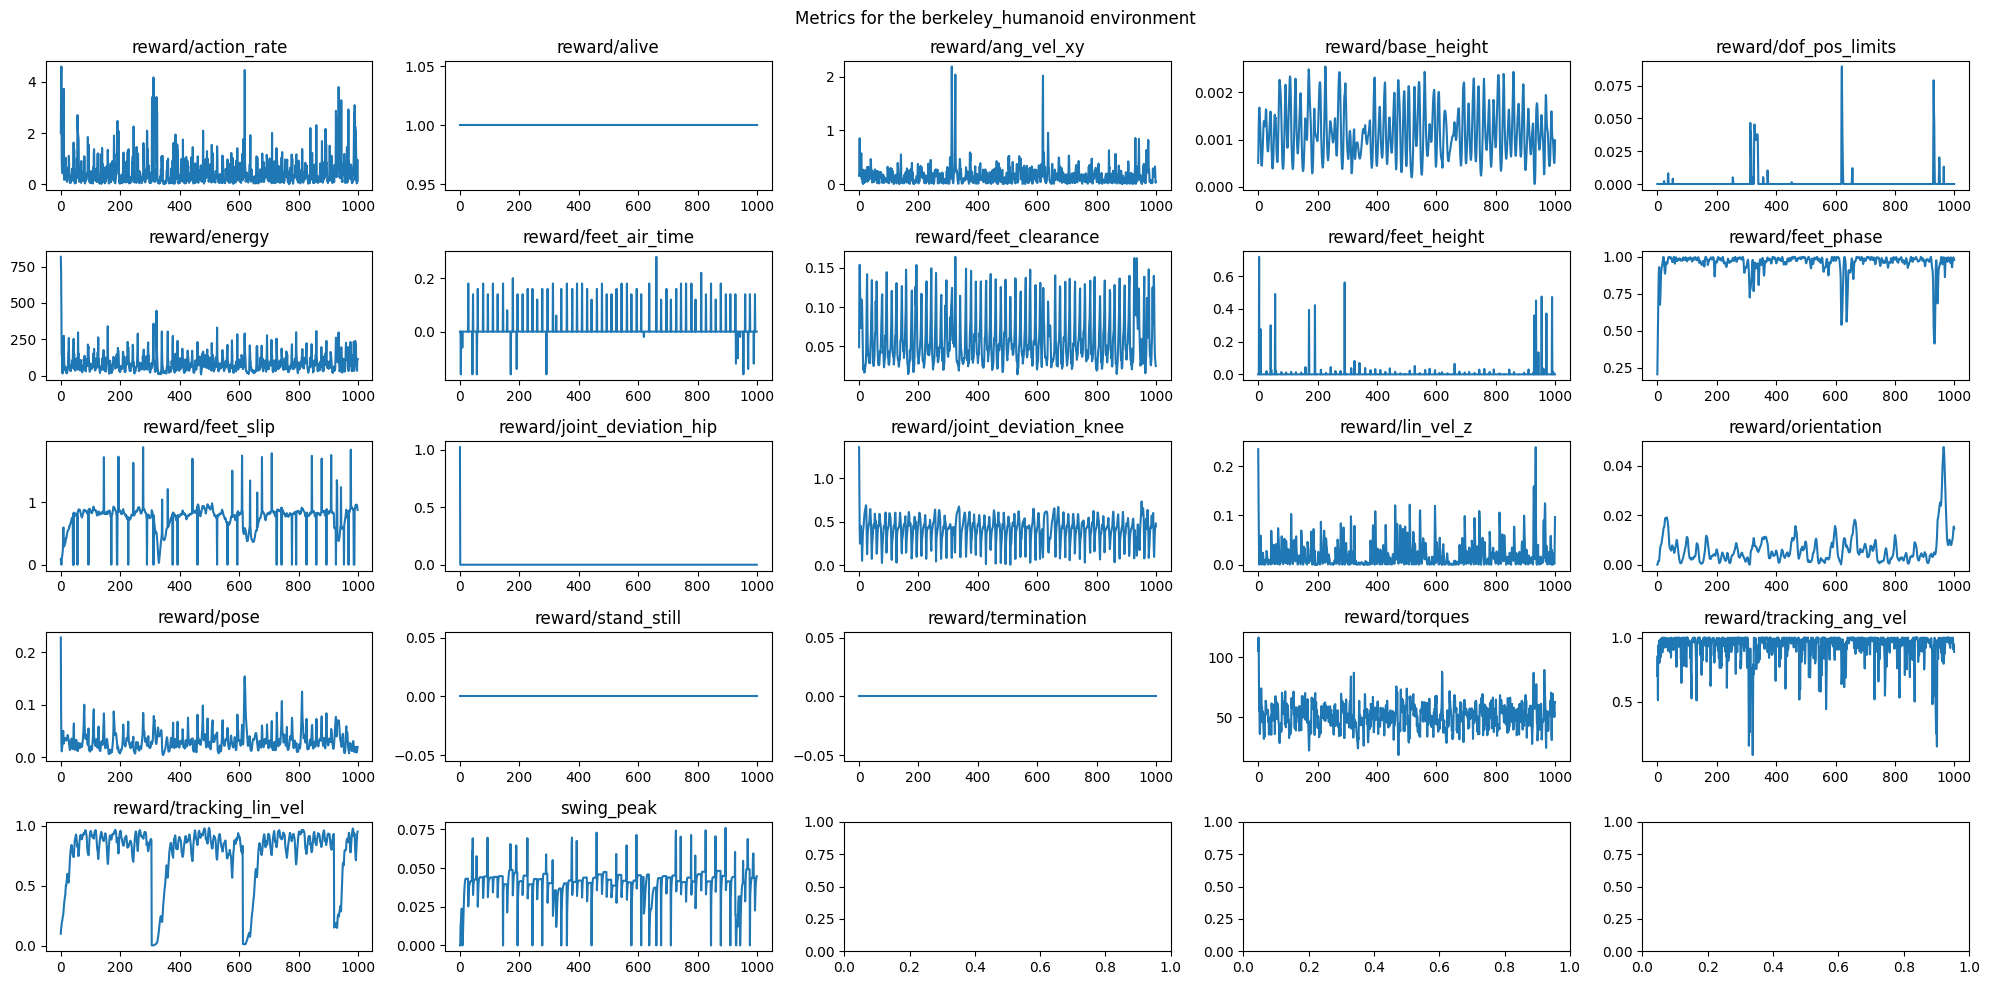

In [ ]:
df = pd.read_csv(ABS_FOLDER_RESUlTS + '/metrics.csv', index_col=0)


fig, ax = plt.subplots(5, 5, figsize=(20, 10))
plt.suptitle('Metrics for the {} environment'.format(env_name))
for i, col in enumerate(df.columns):
    ax[i//5, i%5].plot(df[col])
    ax[i//5, i%5].set_title(col)
plt.tight_layout()
# save fig
fig.savefig(ABS_FOLDER_RESUlTS + '/metrics.png')
plt.show()
